#Кейс

##«Прогнозирование размеров сварного шва при электронно-лучевой сварке тонкостенных конструкций аэрокосмического назначения»

##загрузка данных

In [ ]:
path = 'https://raw.githubusercontent.com/rainewan/luchevaya/main/ebw_data.csv'

##import

In [ ]:
#общие

#ML
from sklearn.linear_model import LinearRegression #линейная регрессия
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RepeatedKFold

from sklearn.neighbors import KNeighborsRegressor  #регрессия на основе метода ближайших соседей
from sklearn.ensemble import GradientBoostingRegressor, StackingRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn import preprocessing #предобработка данных
#metrics
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

#для работы с данными
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import image as plt_image
from tensorflow.keras.preprocessing import image
from PIL import Image

#rpeprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras import utils #для методов обработки признаков (в т.ч. OHE)

#neural networks
from tensorflow.keras.models import Sequential#Последовательная архитектура (слой за слоем)=
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization #Dense слои и нормализация батчей, и дропаут
from tensorflow.keras.layers import Conv2D #двухмерная свертка
from tensorflow.keras.layers import MaxPool2D #слой для извлечения максимальных значений признаков из свёртки
from tensorflow.keras.layers import Flatten #выпрямление матрицы в вектор
from tensorflow.keras.callbacks import EarlyStopping #ранняя остановка
from tensorflow.compat.v1.keras.layers import CuDNNLSTM

from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN, KMeans, AgglomerativeClustering
#clusters metricis
from sklearn.metrics import adjusted_mutual_info_score, adjusted_rand_score, silhouette_score


#Neural networks
import tensorflow as tf # для удобства написания в коде

sns.set_style('darkgrid')
%matplotlib inline

##работа с данными

In [ ]:
data = pd.read_csv(path)
data

,IW,IF,VW,FP,Depth,Width
0,47,139,4.5,80,1.60,2.54
1,47,139,4.5,80,1.62,2.50
2,47,139,4.5,80,1.68,2.60
3,47,139,4.5,80,1.58,2.52
4,45,140,4.5,80,1.76,2.48
...,...,...,...,...,...,...
67,44,146,9.0,60,1.20,1.72
68,45,146,9.0,60,1.36,1.76
69,45,146,9.0,60,1.28,1.76
70,45,146,9.0,60,1.28,1.76


##Смотрим что загрузилось

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72 entries, 0 to 71
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   IW      72 non-null     int64  
 1   IF      72 non-null     int64  
 2   VW      72 non-null     float64
 3   FP      72 non-null     int64  
 4   Depth   72 non-null     float64
 5   Width   72 non-null     float64
dtypes: float64(3), int64(3)
memory usage: 3.5 KB


In [ ]:
data.shape

(72, 6)

###смотрим пропуски

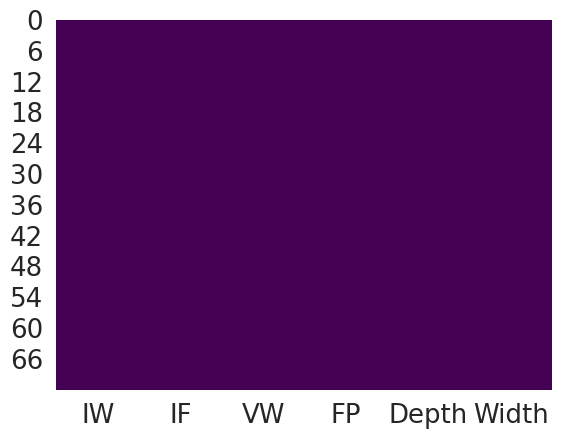

In [ ]:
sns.heatmap(data.isna(), cmap = 'viridis', cbar = False)
plt.show()

In [ ]:
#1.	Снижалась величина сварочного тока (IW);
#2.	Увеличивался ток фокусировки электронного пучка (IF);
#3.	Увеличивалась скорость сварки (VW);
#4.	Менялось расстояние от поверхности образцов до электронно-оптической системы (FP).
#По совокупности параметров технологических режимов обеспечивались минимально
#возможные размеры сварных швов: глубина шва (Depth) и ширина шва (Width)
# описательная статистика
round(data.describe(),2) #округление до 2 знаков после запятой

,IW,IF,VW,FP,Depth,Width
count,72.00,72.00,72.00,72.00,72.00,72.00
mean,45.67,141.33,8.64,78.33,1.20,1.97
std,1.68,5.15,2.06,21.49,0.23,0.28
min,43.00,131.00,4.50,50.00,0.80,1.68
25%,44.00,139.00,8.00,60.00,1.08,1.76
50%,45.50,141.00,9.00,80.00,1.20,1.84
75%,47.00,146.00,10.00,80.00,1.29,2.05
max,49.00,150.00,12.00,125.00,1.76,2.60


In [ ]:
#количество уникальных значений
data.nunique ()

IW        7
IF        8
VW        5
FP        5
Depth    29
Width    25
dtype: int64

In [ ]:
print(data.corr())

             IW        IF        VW        FP     Depth     Width
IW     1.000000 -0.861073 -0.043430  0.835530 -0.289568  0.434869
IF    -0.861073  1.000000  0.115093 -0.980562  0.376084 -0.510167
VW    -0.043430  0.115093  1.000000 -0.001060 -0.671437 -0.874257
FP     0.835530 -0.980562 -0.001060  1.000000 -0.510748  0.412962
Depth -0.289568  0.376084 -0.671437 -0.510748  1.000000  0.425391
Width  0.434869 -0.510167 -0.874257  0.412962  0.425391  1.000000


##Анализ корреляции


Толщина шва антикоррелирует со скоростью сварки. Расстояние от поверхности образцов до электронно-оптической системы коррелирует с Величиной сварочного тока и Антикоррелирует с Током фокусировки электронного пучка

##изучаем целевую переменную


In [ ]:
data['Depth'].value_counts()

1.20    14
1.08     6
1.36     6
1.24     5
1.28     4
1.12     3
0.80     3
0.84     3
1.32     3
1.16     3
1.00     2
0.96     2
1.64     2
0.98     1
0.86     1
1.68     1
1.58     1
1.18     1
1.22     1
1.76     1
0.88     1
1.40     1
1.72     1
1.02     1
0.94     1
0.92     1
1.62     1
1.04     1
1.60     1
Name: Depth, dtype: int64

In [ ]:
data['Width'].value_counts()

1.76    12
1.80     8
2.48     5
1.96     4
1.72     4
1.86     4
1.84     4
1.82     4
2.00     3
2.52     3
1.78     3
2.24     2
2.28     2
1.68     2
1.94     2
2.08     1
2.04     1
2.54     1
2.16     1
1.71     1
2.50     1
1.90     1
2.56     1
2.60     1
1.88     1
Name: Width, dtype: int64

<Axes: >

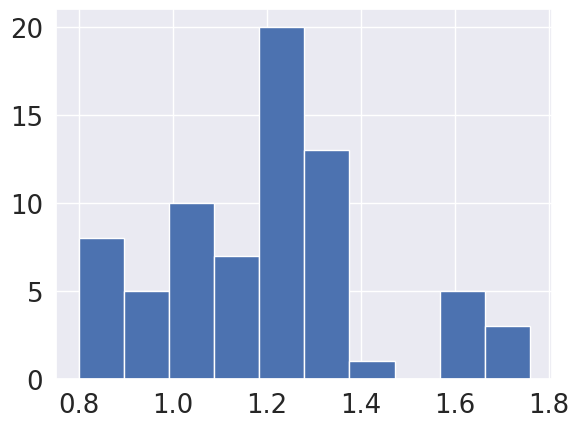

In [ ]:
data['Depth'].hist()

<Axes: >

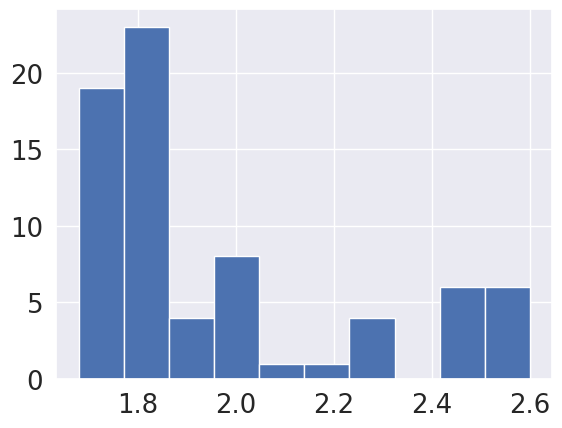

In [ ]:
data['Width'].hist()

##TSNE

In [ ]:
t_sne = TSNE(n_components=2)
t_sne_X = t_sne.fit_transform(data[['IW',	'IF',	'VW',	'FP']])

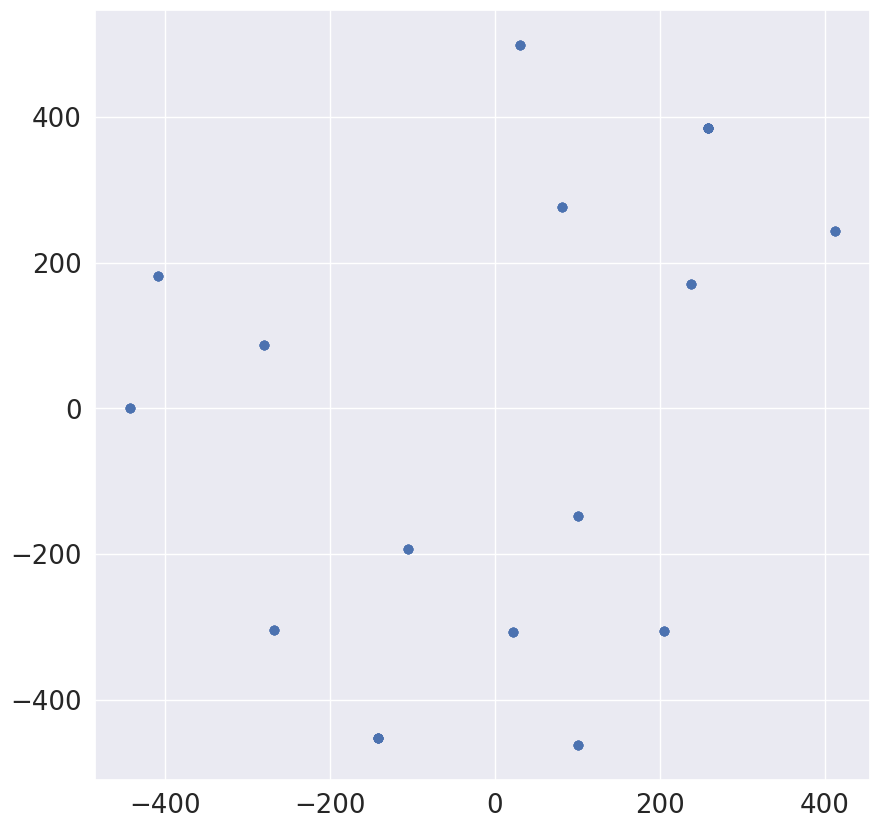

In [ ]:
#plot
plt.figure(figsize = (10,10))
plt.scatter(t_sne_X[:,0], t_sne_X[:, 1])
plt.show()

##кластеризация k-means

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


для 2 кластеров, силуэт = 0.5716758966445923
для 3 кластеров, силуэт = 0.6458303928375244
для 4 кластеров, силуэт = 0.6074731349945068


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


для 5 кластеров, силуэт = 0.5538555979728699


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


для 6 кластеров, силуэт = 0.5643190145492554


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


для 7 кластеров, силуэт = 0.6312221884727478
для 8 кластеров, силуэт = 0.6895468831062317


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


для 9 кластеров, силуэт = 0.6812055110931396


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


для 10 кластеров, силуэт = 0.7648925185203552


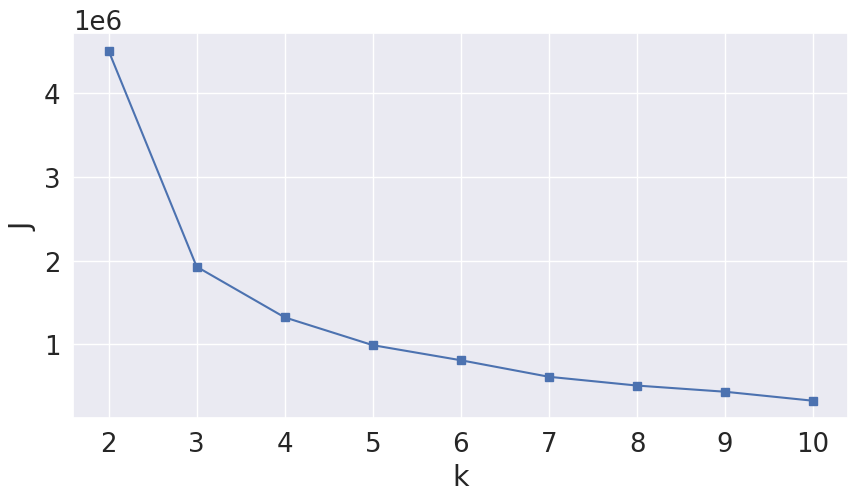

In [ ]:
criteria = [] #список для критерия разбиения на кластеры

for i in range(2, 11):
  km = KMeans(n_clusters = i, random_state = 42)
  km.fit(t_sne_X) #здесь датасет
  criteria.append(km.inertia_)
  print('для {} кластеров, силуэт = {}'.format(i, silhouette_score(t_sne_X, km.labels_)))

plt.figure(figsize = (10,5))
plt.plot(range(2,11), criteria, marker = 's' )
plt.xlabel('k')
plt.ylabel('J')
plt.show()

In [ ]:
km = KMeans(n_clusters = 3, random_state = 42)
km.fit(t_sne_X) #здесь датасет
x_ohe = utils.to_categorical(km.labels_, 3)
print(x_ohe)

[[0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


##Подготовка выборки

###Cоздаем таблицу результатов

In [ ]:
#создаем таблицу результатов
result_table = pd.DataFrame()
result_table['Метрики'] = ['MAPE', 'MSE', 'MAE']

###Создаем X y

In [ ]:
y = np.array(data[['Depth',	'Width']])
X = np.array(data[['IW',	'IF',	'VW',	'FP']])
#X1 = np.array(data[['IW',	'IF',	'VW',	'FP']]) #при использовании тсне
#X = np.column_stack((X1,t_sne_X,x_ohe))

In [ ]:
X[1]

array([ 47. , 139. ,   4.5,  80. ])

In [ ]:
y[1]

array([1.62, 2.5 ])

###Масштабируем данные

In [ ]:
scaler = StandardScaler()
scaler.fit(X) # pkl
X_scaled = scaler.transform(X)

###train test split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y,
                                                    test_size = 0.2,
                                                    shuffle = True,
                                                    random_state = 42)

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(57, 4)
(57, 2)
(15, 4)
(15, 2)


#ML

##RandomForestRegressor

In [ ]:
rf =  RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)


RandomForestRegressor(random_state=42)

In [ ]:
y_pred = rf.predict(X_test).round(2)
print(mean_absolute_percentage_error(y_test, y_pred))
print(mean_squared_error(y_test, y_pred))
print(mean_absolute_error(y_test, y_pred))
result_table['RandomForest'] = mean_absolute_percentage_error(y_test, y_pred), mean_squared_error(y_test, y_pred), mean_absolute_error(y_test, y_pred)

0.032044722716945744
0.004389999999999996
0.04766666666666665


In [ ]:
rf.feature_importances_

array([0.04157222, 0.21855519, 0.62390098, 0.11597161])

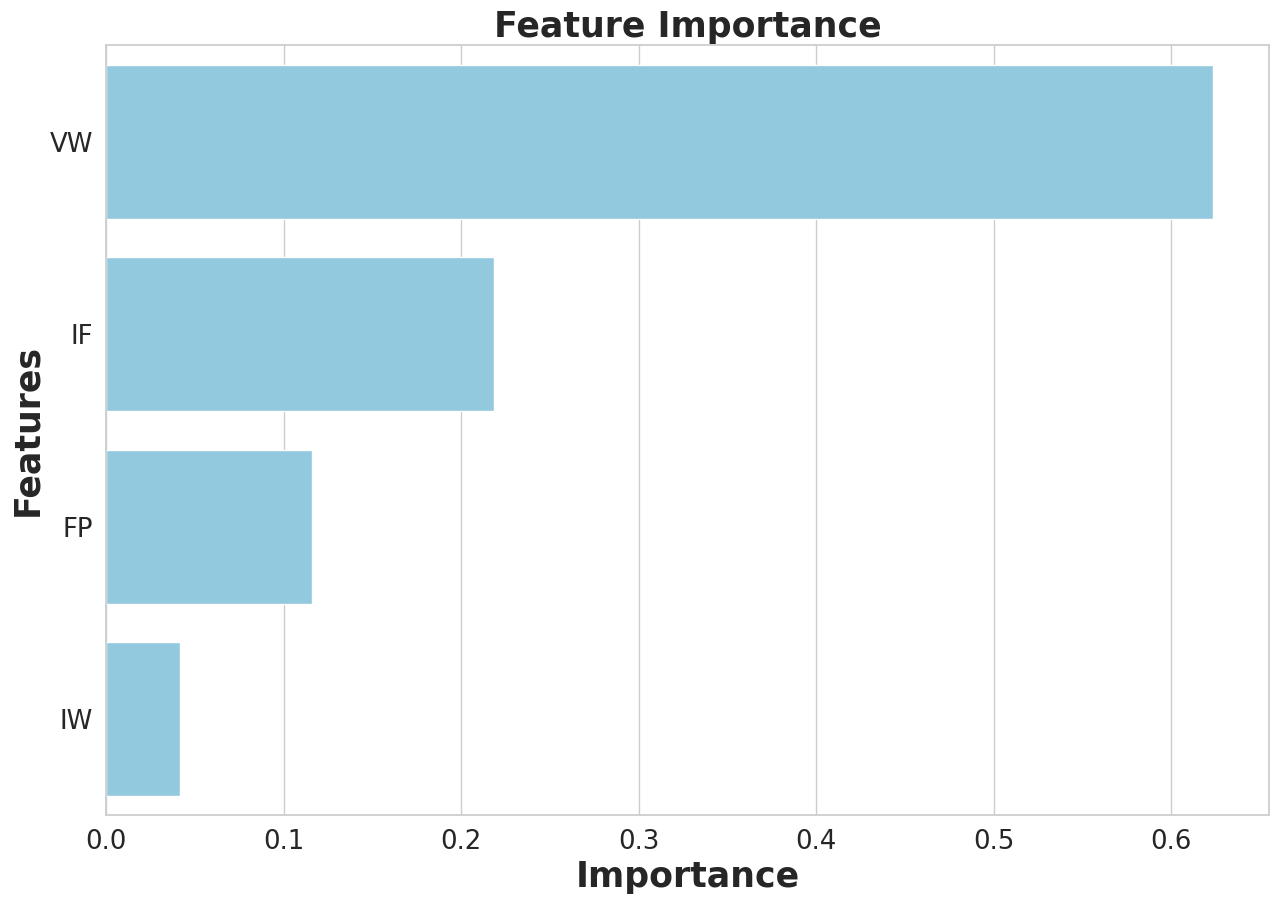

None

,Features,Gini-Importance
0,VW,0.623901
1,IF,0.218555
2,FP,0.115972
3,IW,0.041572


In [ ]:
#важность признаков
feats = {}
for feature, importance in zip(data.columns, rf.feature_importances_):
    feats[feature] = importance
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-Importance'})
importances = importances.sort_values(by='Gini-Importance', ascending=False)
importances = importances.reset_index()
importances = importances.rename(columns={'index': 'Features'})
sns.set(font_scale = 5)
sns.set(style="whitegrid", color_codes=True, font_scale = 1.7)
fig, ax = plt.subplots()
fig.set_size_inches(15,10)
sns.barplot(x=importances['Gini-Importance'], y=importances['Features'], data=importances, color='skyblue')
plt.xlabel('Importance', fontsize=25, weight = 'bold')
plt.ylabel('Features', fontsize=25, weight = 'bold')
plt.title('Feature Importance', fontsize=25, weight = 'bold')
display(plt.show())
display(importances)

##Linear regression

In [ ]:
lr = LinearRegression()
#параметры сетки
param_grid = {'copy_X' : [True, False]}
lr_grid = GridSearchCV(lr,
                       param_grid = param_grid,
                       cv = 5)
#обучаем сетку
lr_grid.fit(X_train, y_train)
print(f'Лучшие параметры : {lr_grid.best_params_}')
print(f'ЛУчшая точность : {lr_grid.best_score_}')

Лучшие параметры : {'copy_X': True}
ЛУчшая точность : 0.8565562329962735


In [ ]:
lr_grid.predict(X_test[:7]).round(2)

array([[1.44, 2.44],
       [1.21, 1.79],
       [1.12, 1.83],
       [1.57, 2.49],
       [1.57, 2.49],
       [1.23, 1.82],
       [1.27, 2.04]])

###Metrics

In [ ]:
y_pred = lr_grid.predict(X_test).round(2)
print(mean_absolute_percentage_error(y_test, y_pred))
print(mean_squared_error(y_test, y_pred))
print(mean_absolute_error(y_test, y_pred))
result_table['Линейная регрессия'] = mean_absolute_percentage_error(y_test, y_pred), mean_squared_error(y_test, y_pred), mean_absolute_error(y_test, y_pred)

0.05224210686583918
0.01215666666666667
0.07766666666666668


In [ ]:
y_pred

array([[1.44, 2.44],
       [1.21, 1.79],
       [1.12, 1.83],
       [1.57, 2.49],
       [1.57, 2.49],
       [1.23, 1.82],
       [1.27, 2.04],
       [0.81, 2.05],
       [1.09, 1.8 ],
       [1.15, 1.75],
       [1.24, 1.75],
       [1.57, 2.49],
       [1.27, 2.04],
       [1.24, 1.75],
       [1.44, 2.44]])

##kNN regressor

In [ ]:
kNNr = KNeighborsRegressor()
#параметры сетки
param_grid = {'n_neighbors' : [4, 6, 10, 13]}
kNNr_grid = GridSearchCV(kNNr,
                       param_grid = param_grid,
                       cv = 5)
#обучаем сетку
kNNr_grid.fit(X_train, y_train)
print(f'Лучшие параметры : {kNNr_grid.best_params_}')
print(f'ЛУчшая точность : {kNNr_grid.best_score_}')

Лучшие параметры : {'n_neighbors': 4}
ЛУчшая точность : 0.883137968104901


###Metrics

In [ ]:
y_pred = kNNr_grid.predict(X_test).round(2)
print(mean_absolute_percentage_error(y_test, y_pred))
print(mean_squared_error(y_test, y_pred))
print(mean_absolute_error(y_test, y_pred))
result_table['Ближайших соседей'] = mean_absolute_percentage_error(y_test, y_pred), mean_squared_error(y_test, y_pred), mean_absolute_error(y_test, y_pred)

0.040000342997495525
0.00581333333333333
0.059333333333333335


In [ ]:
y_pred[:7]


array([[1.56, 2.52],
       [1.25, 1.8 ],
       [1.1 , 1.82],
       [1.49, 2.5 ],
       [1.49, 2.5 ],
       [1.23, 1.81],
       [1.1 , 1.92]])

In [ ]:
y_test[:7]

array([[1.76, 2.48],
       [1.2 , 1.72],
       [1.2 , 1.86],
       [1.6 , 2.54],
       [1.36, 2.52],
       [1.24, 1.8 ],
       [1.16, 1.96]])

##Нейронная сеть

Epoch 1/20
4/4 [==============================] - 7s 70ms/step - loss: 1.4914 - mae: 1.4914 - val_loss: 1.5190 - val_mae: 1.5190
Epoch 2/20
4/4 [==============================] - 0s 11ms/step - loss: 1.3657 - mae: 1.3657 - val_loss: 1.4041 - val_mae: 1.4041
Epoch 3/20
4/4 [==============================] - 0s 11ms/step - loss: 1.2488 - mae: 1.2488 - val_loss: 1.2751 - val_mae: 1.2751
Epoch 4/20
4/4 [==============================] - 0s 11ms/step - loss: 1.1155 - mae: 1.1155 - val_loss: 1.1255 - val_mae: 1.1255
Epoch 5/20
4/4 [==============================] - 0s 14ms/step - loss: 0.9773 - mae: 0.9773 - val_loss: 0.9673 - val_mae: 0.9673
Epoch 6/20
4/4 [==============================] - 0s 11ms/step - loss: 0.8175 - mae: 0.8175 - val_loss: 0.7909 - val_mae: 0.7909
Epoch 7/20
4/4 [==============================] - 0s 11ms/step - loss: 0.6402 - mae: 0.6402 - val_loss: 0.6244 - val_mae: 0.6244
Epoch 8/20
4/4 [==============================] - 0s 11ms/step - loss: 0.5316 - mae: 0.5316 - val

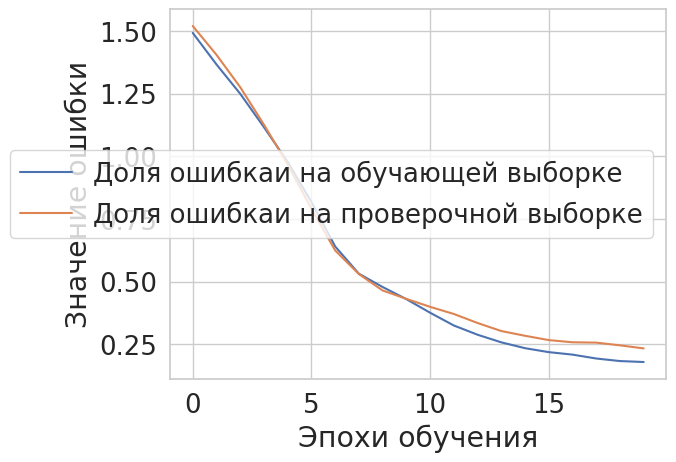

In [ ]:
#создаем архитектуру нейронной сети
model = Sequential()
#model.add(BatchNormalization()) #отдельная номрализация именно батча

model.add(tf.keras.Input(shape = (X_train.shape[1], ))) #входная размерность
model.add(Dense(57, activation = 'relu'))#входной слой 57 нейронов

#model.add(BatchNormalization()) #отдельная номрализация именно батча

model.add(Dense(57, activation = 'relu'))#скрытый слой 57
#model.add(Dropout(0.33)) #случайным образом убираем нейроны в слое

model.add(Dense(57, activation = 'relu'))#скрытый слой

model.add(Dense(y.shape[1], activation = 'linear'))#выходной слой должен содержать кол-во нейронов по числу классов в Y

#компилируем нейронную сети
model.compile(loss= 'mae', #ошибка
              optimizer = 'adam', #градиентный спуск
              metrics = ['mae'])#метрика

#Early stopping - останавливает обучение, после того, как ошибка последовательно растет n эпох
es = EarlyStopping(monitor = 'val_loss',
                   mode = 'min',
                   patience = 10,
                   verbose = 1)

#обучаем нейронную сеть
history = model.fit(X_train, y_train,
          batch_size = 15, #сколько объектов пожается за разх в нейронку
          epochs = 20,  #сколько циклов по выборке пройдет нейронка
          validation_data = (X_test, y_test),
          verbose = 1,
          callbacks = [es] )#визуализация процесса обучения

#визуализация обучения нейронки
plt.plot(history.history['loss'],
         label = 'Доля ошибкаи на обучающей выборке')
plt.plot(history.history['val_loss'],
         label = 'Доля ошибкаи на проверочной выборке')
plt.xlabel('Эпохи обучения')
plt.ylabel('Значение ошибки')
plt.legend()
plt.show()

###Metrics

In [ ]:
#прогноз
y_pred = model.predict(X_test).round(2)
print(mean_absolute_percentage_error(y_test, y_pred))
print(mean_squared_error(y_test, y_pred))
print(mean_absolute_error(y_test, y_pred))
result_table['Нейронная сеть'] = mean_absolute_percentage_error(y_test, y_pred), mean_squared_error(y_test, y_pred), mean_absolute_error(y_test, y_pred)

1/1 [==============================] - 0s 86ms/step
0.1495720544463643
0.10797665512085142
0.23366665522257485


#Результирующая таблица

In [ ]:
#Результирующая таблица
print(result_table)

  Метрики  RandomForest  Линейная регрессия  Ближайших соседей  Нейронная сеть
0    MAPE      0.032045            0.052242           0.040000        0.149572
1     MSE      0.004390            0.012157           0.005813        0.107977
2     MAE      0.047667            0.077667           0.059333        0.233667


#Вывод:

##Меньше всего дает ошибку метод Случайный лес. Его и будем использовать в качестве модели для прогноза. Для нейронной сети слишком мало данных, чтобы качественно её обучить.

##проверка модели на примере

In [ ]:
#вводим переменную случайную
X_primer = np.array([[45.,	170.,	6.,	90.]])
print(X_primer[0])

#маштабируем пример
X_primer_scale = scaler.transform(X_primer) #
print(X_primer_scale)

#прогнозируем пример с положительными значениями
np.absolute(rf.predict(X_primer_scale).round(2))

[ 45. 170.   6.  90.]
[[-0.4         5.61002143 -1.2893288   0.54660817]]


array([[1.62, 2.51]])

In [ ]:
#вводим переменную случайную, ответ 1.2	1.68
X_primer = np.array([[44.,	146.,	9.,	60.]])
print(X_primer[0])

#маштабируем пример
X_primer_scale = scaler.transform(X_primer) #
print(X_primer_scale)

#прогнозируем пример
rf.predict(X_primer_scale).round(2)

[ 44. 146.   9.  60.]
[[-1.          0.9132593   0.17643447 -0.85895569]]


array([[1.23, 1.8 ]])